In [1]:
import warnings
warnings.filterwarnings("ignore")
import glob
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from IPython.display import clear_output

In [2]:
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go

In [3]:
plotly.offline.init_notebook_mode(connected=True)

In [4]:
import sys
sys.path.append("../pyfiles/")
from util import * 
from dataset import * 
from model import * 
from util_notebook import *

# Get celebA dataset

In [5]:
label_discription = [
    "male, smiling",
    "male, not smiling",
    "female, smiling",
    "female, not smiling"
]

In [6]:
root = "./../../dataset/celebA/img/"
label_root = "./../../dataset/celebA/label_folder/"

In [7]:
# 1 5 o clock shadow
# 11 blurry
# 14 chubby
# 15 double chin
# 16 eyeglasses
# 17 goatee
# 21 male
# 23 mustache
# 25 No_Beard
# 31 sideburns
# 32 smiling
# 36 wearing hat
# 40 young
dataset_label = {}
dataset_label["existed"] = [25] 
dataset_label["delete"] = [1, 11, 14, 15, 16, 17, 23, 31, 36] 
dataset_label["class"] = [21, 32] 

In [8]:
classes = tuple(range(2**len(dataset_label["class"])))
cl = get_class_label(len(dataset_label["class"]))
classes

(0, 1, 2, 3)

In [9]:
transform = {}
transform["train"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    MinMax(True),
])
    
transform["test"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    MinMax(True),
])

In [10]:
each_train_num = 10000000
each_val_num = 0
each_test_num = 100
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
len(dataset), len(testset)

(134530, 400)

0


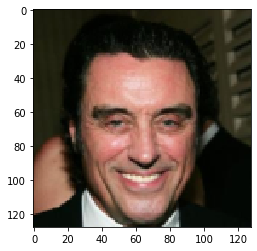

In [11]:
data = dataloader.dataset[24]
img = data[0]
image = image_from_output(torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2])))[0]
print(data[1])
plt.imshow(image)

## Algorithm

# conditional GAN

In [12]:
epoch_num = 31
lr_D = 0.0001
lr_G = 0.0002
lr_E = 0.001
# torch.cuda.set_device("cuda:4")
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
# ---- adjustable parameters ---- #
ndim = 8 # the dimension of noise vector, indicating the style
nch_in = 3
nch = 64
reduce = 2
num_cls = 2
res_num = 6
dis_reduce = 2
dis_nch = 64
dis_num_cls = 4

model_type = "nopretraining" # "nopretraining", "gradattention", "pretrained"
attention_mode = "" # this will be available when you set 'model_type' as "gradattention": "relu", "relumodified"
restriction_type = "proposedKL" # "conventionalKL", "proposedKL"
styleINdataset = False
save_parameter = True
###################################

if restriction_type == "conventionalKL":
    encoded_feature = "latent" # "latent" or "mu"
elif restriction_type == "proposedKL":
    encoded_feature = "mu" # "latent" or "mu"
if styleINdataset:
    styleINdataset_or_not = "styleINdataset_"
else:
    styleINdataset_or_not = ""
ref_label = np.eye(len(classes))
hi = histogram_imitation(device)

In [14]:
devices = [0,1,2,3]
netG = SingleGenerator(nch_in, nch, reduce, num_cls, res_num, "instance", num_con=ref_label.shape[1]+ndim).to(device)
netG.apply(weights_init)
netG = nn.DataParallel(netG, devices)
netD = SingleDiscriminator_solo_multi(nch_in, dis_nch, dis_reduce, dis_num_cls, "instance", ref_label.shape[1]).to(device)
netD.apply(weights_init)
netD = nn.DataParallel(netD, devices)
if model_type in ["nopretraining", "pretrained"]:
    netE = Encoder_original(nch_in, ndim, nch, 4, "instance", ref_label.shape[1]).to(device)
elif model_type=="gradattention":
    netE = Encoder_gradattention(nch_in, ndim, nch, 4, "instance", ref_label.shape[1], attention_mode).to(device)
netE.apply(weights_init);

In [15]:
if model_type in ["gradattention", "pretrained"]:
    model_path = f"./model_parameters/Mpaper/72/facial_recognizer_lr0.0001_epoch51.pth"
    netE = load_classifier(netE, model_path)
    classifier = Encoder_classifier(nch_in, ndim, nch, 4, norm_type, ref_label.shape[1]).to(device)
    classifier_layers = list(classifier.state_dict().keys())
    netE.freeze_melt(classifier_layers, "freeze")
    optE = optim.Adam(filter(lambda p: p.requires_grad, netE.parameters()), lr=0.001, betas=(0.5, 0.999))
    netE.freeze_melt(classifier_layers, "melt");
else:
    optE = None
netE = nn.DataParallel(netE, devices)

In [16]:
criterion = nn.MSELoss()
criterion_class = nn.MSELoss()

## train

In [17]:
lbd = {}
lbd["class"] = 1
lbd["cycle"] = 5
lbd["idt"] = 5
lbd["reg"] = 0.5
lbd["idt_reg"] = 0.5

if restriction_type == "conventionalKL":
    lbd["KL"] = 0.1
    lbd["batch_KL"] = 0
    lbd["corr_enc"] = 0
    lbd["hist"] = 0
elif restriction_type == "proposedKL":
    lbd["KL"] = 0
    lbd["batch_KL"] = 10
    lbd["corr_enc"] = 100
    lbd["hist"] = 100
    
unrolled_k = 5

In [18]:
each_train_num = 10000
batch_size = 128
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=0, test_num=100)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
sampleset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=16)
len(dataset), len(sampleset)

(40000, 64)

In [19]:
sg = SingleGAN_training_singleD([netG, netD, netE], [None, None, optE], [criterion, criterion_class], 
                       lbd, unrolled_k, device, ref_label, ndim, batch_size, encoded_feature)
sg.opt_sche_initialization()

epoch 22 :itr 106/312: 6.9292924722035725 mins


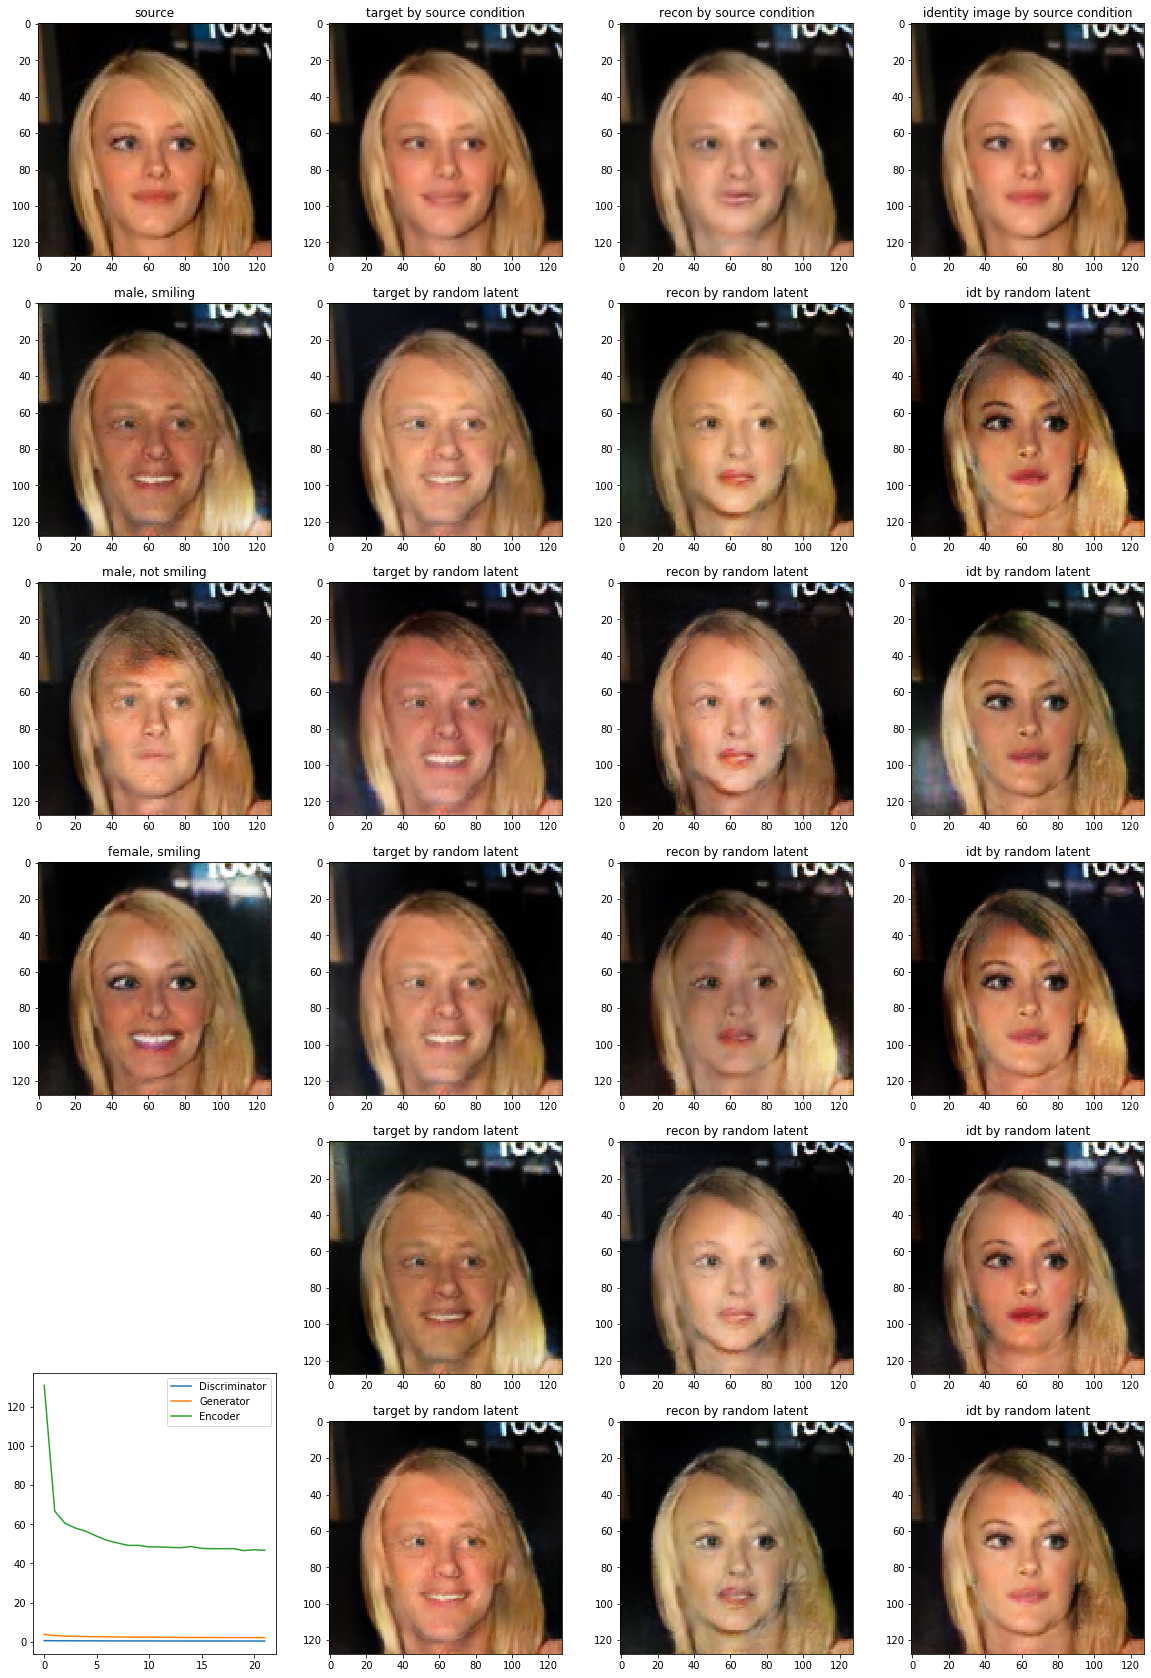

In [ ]:
run_train = True
if run_train:
    interval = int(len(dataset)/batch_size/3) + 2
    losses_D = []
    losses_G = []
    losses_E = []
    for epoch in range(epoch_num):
        start_time = time.time()
        loss_D = []
        loss_G = []
        loss_E = []
        for itr, data in enumerate(dataloader):
            netG.train()
            data_image = data[0]
            data_label = data[1]

            source_image = data_image.to(device)
            label = {}

            label["source"] = data_label.to(device)
            whole_target = get_target(data_label, classes, whole=False)
            label["target"] = torch.tensor(whole_target[:,0], dtype=torch.long, device="cpu")

            errG, errD, errE = sg.train(source_image, label)

            if type(errD)!=int:
                errD = errD.detach().to("cpu").numpy()
                loss_D.append(errD)
            if type(errG)!=int:
                errG = errG.detach().to("cpu").numpy()
                loss_G.append(errG)
            if type(errE)!=int:
                errE = errE.detach().to("cpu").numpy()
                loss_E.append(errE)

            if itr%interval==0:
                if not itr==0:
                    clear_output(wait=True)
                    print(f"epoch {epoch} :itr {itr}/{int(len(dataset)/batch_size)}: {(time.time()-start_time)/60} mins")
                    fig = get_output_and_plot(sg, sampleset, 53, [classes, label_discription], 5, styleINdataset, device)

                    if not epoch==0:
                        length = 5
                        width = 4
                        losses = [losses_D, losses_G, losses_E]
                        ax = fig.add_subplot(length, width, 17)
                        models = ["Discriminator", "Generator", "Encoder"]
                        for k in range(len(losses)):
                            if models[k] == "Discriminator":
                                if type(losses[k]) == dict:
                                    for i in classes:
                                        ax.plot(losses[k][i], label=f"Discriminator-{i}")
                                elif type(losses[k]) == list:
                                    ax.plot(losses[k], label=f"Discriminator")
                            else:
                                ax.plot(losses[k], label=models[k])
                        ax.legend()
                    plt.show()

        if save_parameter:
            if epoch % 3 == 0:
                dir = "./instant_model_parameter/"
                gen_path = dir + f"gen_singleD_SingleGAN_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_reg{lbd['reg']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}"
                dis_path = dir + f"dis_singleD_SingleGAN_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_reg{lbd['reg']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}"
                enc_path = dir + f"enc_singleD_SingleGAN_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_reg{lbd['reg']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}"

                torch.save(sg.G.module.state_dict(), gen_path)
                torch.save(sg.D.module.state_dict(), dis_path)
                torch.save(sg.E.module.state_dict(), enc_path)

        sg.scheD.step()
        losses_D.append(np.mean(loss_D))
        sg.scheG.step()
        losses_G.append(np.mean(loss_G))
        sg.scheE.step()
        losses_E.append(np.mean(loss_E))

        clear_output(wait=True)
        print(f"{epoch+1}: {(time.time()-start_time)/60} mins")
        fig = get_output_and_plot(sg, sampleset, 53, [classes, label_discription], 5, styleINdataset, device)

        length = 5
        width = 4
        losses = [losses_D, losses_G, losses_E]
        ax = fig.add_subplot(length, width, 17)
        models = ["Discriminator", "Generator", "Encoder"]
        for k in range(len(losses)):
            if models[k] == "Discriminator":
                if type(losses[k]) == dict:
                    for i in classes:
                        ax.plot(losses[k][i], label=f"Discriminator-{i}")
                elif type(losses[k]) == list:
                    ax.plot(losses[k], label=f"Discriminator")
            else:
                ax.plot(losses[k], label=models[k])
        ax.legend()

        plt.show()